In [597]:
using Random


# Basics of random number generation

In [614]:
uniform_sample_in_zero_maxval(n_features, maxval) = maxval.*(1 .- rand(n_features)) 

uniform_sample_in_minval_maxval(n_features, minval, maxval) = (maxval-minval)* rand(n_features) .+ minval 

# x=rand() is a sample from N(0,1) =>  x2 = mu + sqrt(std)*rand() is a sample from  N(mu, std)
normal_sample(n_features, mu, var) = mu .+ sqrt(var) .* randn(n_features)

normal_sample (generic function with 1 method)

In [528]:
maxval = 10
uniform_sample_in_zero_maxval(n_features, maxval)

2-element Array{Float64,1}:
 3.414183833053548
 7.357106323716145

In [529]:
maxval = 3
uniform_sample_in_zero_maxval(n_features, maxval)

2-element Array{Float64,1}:
 2.3754101224398196
 2.990285852392768 

In [530]:
minval = 2
maxval = 10

uniform_sample_in_minval_maxval(n_features ,minval, maxval)

2-element Array{Float64,1}:
 9.501452368180022 
 6.6303713472296675

# Blob generator

In [809]:
# make blobs
function make_blobs(n_examples=100; n_features=2, 
                    centers=3, cluster_std=1.0, center_box=(-10.,10.),
                    element_type=Float64, random_seed=1234, return_centers=false)

    Random.seed!(random_seed)

    X = [] 
    y = []

    if typeof(centers)<: Int
        n_centers = centers
        centers = []
        for c in 1:n_centers
            #center_sample = uniform_sample_in_range(n_features, center_box[1],center_box[1])
            center_sample = uniform_sample_in_minval_maxval(n_features, center_box[1], center_box[2])
            push!(centers, center_sample)
        end
    else
        n_centers = length(centers)
    end

    if typeof(cluster_std)<: AbstractFloat
        cluster_std = 0.5 * randn(n_centers)
    end
    
    # generate the nunber of example for each center
    n_examples_per_center = [div(n_examples, n_centers) for x  in 1:n_centers]
    for i in 1:(n_examples % n_centers)
        n_examples_per_center[i] += 1
    end

    #println("len(centers)=",length(centers))
    #println("len(n_examples_per_center)=",length(n_examples_per_center))
    #println("len(cluster_std)=",length(cluster_std))

    # Generate the actual vectors close to each center blob 
    for (i, (n, std, center)) in enumerate(zip(n_examples_per_center, cluster_std, centers))
        X_current = center' .+ std .* randn(element_type, (n, n_features))
        push!(X, X_current)
        push!(y, [i for k in 1:n]) 
    end

    # get a single Array that stacks all the previous arrays created for each of the centers
    X = cat(X..., dims=1)
    y = cat(y..., dims=1)
    
    if return_centers
        return X,y,centers  
    else
        return X, y
    end
    
end

make_blobs (generic function with 9 methods)

In [810]:
X, y, c = make_blobs(100; centers=3, random_seed=7, return_centers=true)

([6.332915719469112 3.166051622301798; 6.288894614085511 3.12579462724647; … ; 0.7502503697316767 -4.076539492007584; -0.4812645016839405 -5.602620547796109], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], Any[[6.248771644015054, 3.099549292674503], [-0.20773239304314295, -8.424809288622503], [1.6318126225038334, -4.83893336846454]])

In [811]:
c

3-element Array{Any,1}:
 [6.248771644015054, 3.099549292674503]    
 [-0.20773239304314295, -8.424809288622503]
 [1.6318126225038334, -4.83893336846454]   

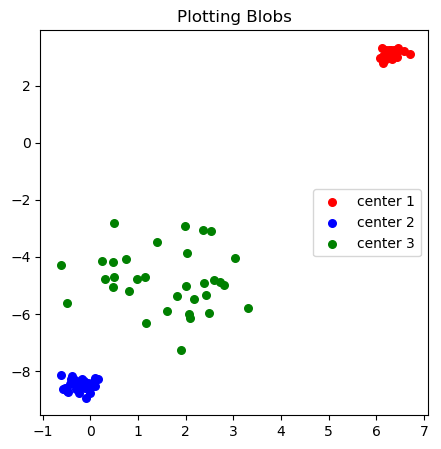

PyObject <matplotlib.legend.Legend object at 0x14b597ac8>

In [814]:
using PyPlot

X1 = X[y.==1,:]
X2 = X[y.==2,:]
X3 = X[y.==3,:]

fig = figure(figsize=(5,5))
title("Plotting Blobs")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "center 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "center 2", s = 30)
B = scatter(X3[:,1],X3[:,2],color="green", label = "center 3", s = 30)
legend(loc="right")
#savefig("blobs.pdf")  

In [813]:
c

3-element Array{Any,1}:
 [6.248771644015054, 3.099549292674503]    
 [-0.20773239304314295, -8.424809288622503]
 [1.6318126225038334, -4.83893336846454]   

# Circles generator

Make a circle containing another circle in 2d (mmake a ring with a ball inside).




In [679]:
"""
    Return evenly spaced numbers over a specified interval.
    
    Returns `num` evenly spaced samples, calculated over the
    interval [`start`, `stop`].
    
    The endpoint of the interval can optionally be excluded.

"""
function linspace(start, stop; num=50, endpoint=true, retstep=false)
    dif  = stop-start
    step = dif/num
    result = []
       
    if endpoint 
        for i in 1:num
            push!(result, start+i*step)
        end
    else
        for i in 1:num
            push!(result, start+(i-1)*step)
        end
    end
    return result
    
end

linspace

In [792]:
function shuffle_Xy(X, y; random_seed=1234)
    Random.seed!(random_seed)
    perm = randperm(length(y))
    return X[perm,:], y[perm]
end

function make_circles(n_samples=100; shuffle=true, noise=0., random_seed=1234, factor=0.8)
    
    @assert 0 <= factor <=1  #factor in [0,1] 

    n_samples_out = div(n_samples, 2)
    n_samples_in = n_samples - n_samples_out
     
    linspace_out = linspace(0, 2 * pi; num=n_samples_out, endpoint=false)
    linspace_in  = linspace(0, 2 * pi; num=n_samples_in, endpoint=false)

    outer_circ_x = cos.(linspace_out)
    outer_circ_y = sin.(linspace_out)
    inner_circ_x = cos.(linspace_in) .* factor
    inner_circ_y = sin.(linspace_in) .* factor
    
    X = [[outer_circ_x..., inner_circ_x...] [outer_circ_y..., inner_circ_y...]]
    y = [ones(Int,n_samples_out)..., 2*ones(Int,n_samples_in)...]

    if shuffle
       X, y = shuffle_Xy(X, y ; random_seed=random_seed)
    end
    
    if noise >0.
        X .= X .+ noise.* rand(size(X)...)
    end

    return X,y
end

make_circles (generic function with 2 methods)

In [796]:
X,y = make_circles(100);

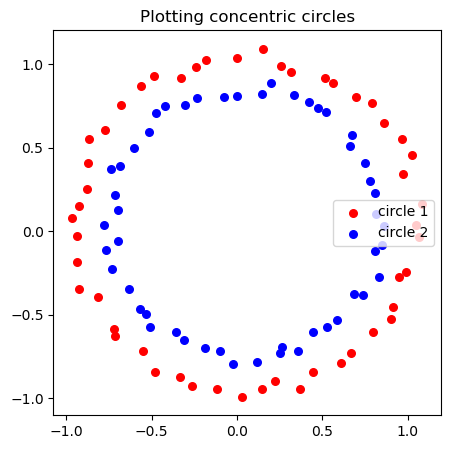

PyObject <matplotlib.legend.Legend object at 0x14b0e6860>

In [806]:
using PyPlot

X1 = X[y.==1,:]
X2 = X[y.==2,:]

fig = figure(figsize=(5,5))
title("Plotting concentric circles")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "circle 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "circle 2", s = 30)
legend(loc="right")
#savefig("concentric_circles.pdf")  

In [803]:
X,y = make_circles(100;noise=0.1);

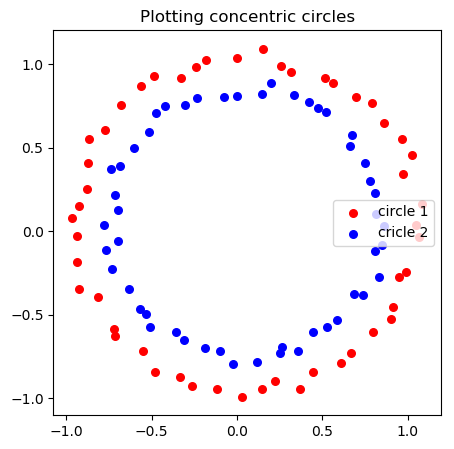

PyObject <matplotlib.legend.Legend object at 0x14aef66a0>

In [805]:
using PyPlot

X1 = X[y.==1,:]
X2 = X[y.==2,:]

fig = figure(figsize=(5,5))
title("Plotting concentric circles")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "circle 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "cricle 2", s = 30)
legend(loc="right")
#savefig("concentric_circles.pdf")  

# Make moons

In [816]:
function make_moons(n_samples=100; shuffle=true, noise=0., translation=0.5, random_seed=1234)
    
    @assert 0 <= factor <=1  #factor in [0,1] 

    n_samples_out = div(n_samples, 2)
    n_samples_in = n_samples - n_samples_out
     
    linspace_out = linspace(0, pi; num=n_samples_out, endpoint=true)
    linspace_in  = linspace(0, pi; num=n_samples_in, endpoint=true)

    

    outer_circ_x = cos.(linspace_out)
    outer_circ_y = sin.(linspace_out)
    inner_circ_x = 1 .- cos.(linspace_in) .* factor
    inner_circ_y = 1 .- sin.(linspace_in) .* factor .- translation
    
    X = [[outer_circ_x..., inner_circ_x...] [outer_circ_y..., inner_circ_y...]]
    y = [ones(Int,n_samples_out)..., 2*ones(Int,n_samples_in)...]

    if shuffle
       X, y = shuffle_Xy(X, y ; random_seed=random_seed)
    end
    
    if noise >0.
        X .= X .+ noise.* rand(size(X)...)
    end

    return X,y
end

make_moons (generic function with 2 methods)

In [817]:
X,y = make_moons(100;noise=0.1);

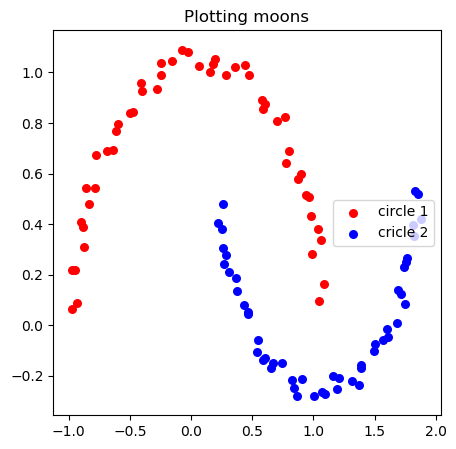

PyObject <matplotlib.legend.Legend object at 0x14b719f28>

In [819]:
using PyPlot

X1 = X[y.==1,:]
X2 = X[y.==2,:]

fig = figure(figsize=(5,5))
title("Plotting moons")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "circle 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "cricle 2", s = 30)
legend(loc="right")

In [820]:
X,y = make_moons(100; noise=0.1, translation=1.0);

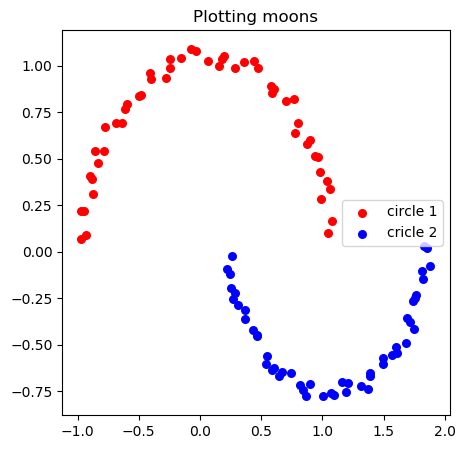

PyObject <matplotlib.legend.Legend object at 0x14b97df98>

In [822]:
using PyPlot

X1 = X[y.==1,:]
X2 = X[y.==2,:]

fig = figure(figsize=(5,5))
title("Plotting moons")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "circle 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "cricle 2", s = 30)
legend(loc="right")

In [823]:
X,y = make_moons(100; noise=0.4, translation=0.4);

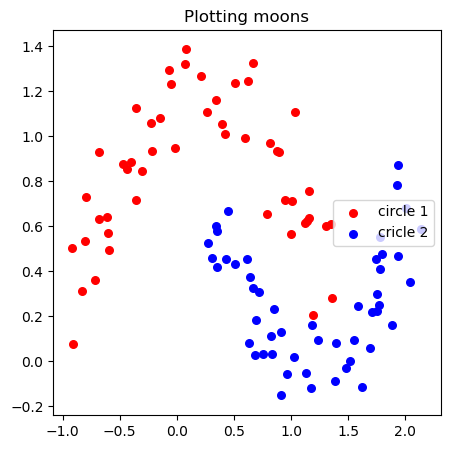

PyObject <matplotlib.legend.Legend object at 0x14babb9b0>

In [824]:
using PyPlot

X1 = X[y.==1,:]
X2 = X[y.==2,:]

fig = figure(figsize=(5,5))
title("Plotting moons")
R = scatter(X1[:,1],X1[:,2],color="red",   label = "circle 1", s = 30)
G = scatter(X2[:,1],X2[:,2],color="blue",  label = "cricle 2", s = 30)
legend(loc="right")